In [17]:
from __future__ import division
import cv2
import numpy as np
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import matplotlib.pyplot as plot
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
class LaneDetector:
    def __init__(self, road_horizon, prob_hough=True):
        self.prob_hough = prob_hough
        self.vote = 50
        self.roi_theta = 0.3
        self.road_horizon = road_horizon

    def _standard_hough(self, img, init_vote):
        # Hough transform wrapper to return a list of points like PHough does
        lines = cv2.HoughLines(img, 1, np.pi/180, init_vote)
        points = [[]]
        for l in lines:
            for rho, theta in l:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*a)
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*a)
                points[0].append((x1, y1, x2, y2))
        return points

    def _base_distance(self, x1, y1, x2, y2, width):
        # compute the point where the give line crosses the base of the frame
        # return distance of that point from center of the frame
        if x2 == x1:
            return (width*0.5) - x1
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        base_cross = -c/m
        return (width*0.5) - base_cross

    def _scale_line(self, x1, y1, x2, y2, frame_height):
        # scale the farthest point of the segment to be on the drawing horizon
        if x1 == x2:
            if y1 < y2:
                y1 = self.road_horizon
                y2 = frame_height
                return x1, y1, x2, y2
            else:
                y2 = self.road_horizon
                y1 = frame_height
                return x1, y1, x2, y2
        if y1 < y2:
            m = (y1-y2)/(x1-x2)
            x1 = ((self.road_horizon-y1)/m) + x1
            y1 = self.road_horizon
            x2 = ((frame_height-y2)/m) + x2
            y2 = frame_height
        else:
            m = (y2-y1)/(x2-x1)
            x2 = ((self.road_horizon-y2)/m) + x2
            y2 = self.road_horizon
            x1 = ((frame_height-y1)/m) + x1
            y1 = frame_height
        return x1, y1, x2, y2

    def detect(self, frame):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        roiy_end = frame.shape[0]
        roix_end = frame.shape[1]
        roi = img[self.road_horizon:roiy_end, 0:roix_end]
        blur = cv2.medianBlur(roi, 5)
        contours = cv2.Canny(blur, 60, 120)

        if self.prob_hough:
            lines = cv2.HoughLinesP(contours, 1, np.pi/180, self.vote, minLineLength=30, maxLineGap=100)
        else:
            lines = self.standard_hough(contours, self.vote)

        if lines is not None:
            # find nearest lines to center
            lines = lines+np.array([0, self.road_horizon, 0, self.road_horizon]).reshape((1, 1, 4))  # scale points from ROI coordinates to full frame coordinates
            left_bound = None
            right_bound = None
            for l in lines:
                # find the rightmost line of the left half of the frame and the leftmost line of the right half
                for x1, y1, x2, y2 in l:
                    theta = np.abs(np.arctan2((y2-y1), (x2-x1)))  # line angle WRT horizon
                    if theta > self.roi_theta:  # ignore lines with a small angle WRT horizon
                        dist = self._base_distance(x1, y1, x2, y2, frame.shape[1])
                        if left_bound is None and dist < 0:
                            left_bound = (x1, y1, x2, y2)
                            left_dist = dist
                        elif right_bound is None and dist > 0:
                            right_bound = (x1, y1, x2, y2)
                            right_dist = dist
                        elif left_bound is not None and 0 > dist > left_dist:
                            left_bound = (x1, y1, x2, y2)
                            left_dist = dist
                        elif right_bound is not None and 0 < dist < right_dist:
                            right_bound = (x1, y1, x2, y2)
                            right_dist = dist
            if left_bound is not None:
                left_bound = self._scale_line(left_bound[0], left_bound[1], left_bound[2], left_bound[3], frame.shape[0])
            if right_bound is not None:
                right_bound = self._scale_line(right_bound[0], right_bound[1], right_bound[2], right_bound[3], frame.shape[0])

            return [left_bound, right_bound]

In [3]:
class LaneTracker:
    def __init__(self, n_lanes, proc_noise_scale, meas_noise_scale, process_cov_parallel=0, proc_noise_type='white'):
        self.n_lanes = n_lanes
        self.meas_size = 4 * self.n_lanes
        self.state_size = self.meas_size * 2
        self.contr_size = 0

        self.kf = cv2.KalmanFilter(self.state_size, self.meas_size, self.contr_size)
        self.kf.transitionMatrix = np.eye(self.state_size, dtype=np.float32)
        self.kf.measurementMatrix = np.zeros((self.meas_size, self.state_size), np.float32)
        for i in range(self.meas_size):
            self.kf.measurementMatrix[i, i*2] = 1

        if proc_noise_type == 'white':
            block = np.matrix([[0.25, 0.5],
                               [0.5, 1.]], dtype=np.float32)
            self.kf.processNoiseCov = block_diag(*([block] * self.meas_size)) * proc_noise_scale
        if proc_noise_type == 'identity':
            self.kf.processNoiseCov = np.eye(self.state_size, dtype=np.float32) * proc_noise_scale
        for i in range(0, self.meas_size, 2):
            for j in range(1, self.n_lanes):
                self.kf.processNoiseCov[i, i+(j*8)] = process_cov_parallel
                self.kf.processNoiseCov[i+(j*8), i] = process_cov_parallel

        self.kf.measurementNoiseCov = np.eye(self.meas_size, dtype=np.float32) * meas_noise_scale

        self.kf.errorCovPre = np.eye(self.state_size)

        self.meas = np.zeros((self.meas_size, 1), np.float32)
        self.state = np.zeros((self.state_size, 1), np.float32)

        self.first_detected = False

    def _update_dt(self, dt):
        for i in range(0, self.state_size, 2):
            self.kf.transitionMatrix[i, i+1] = dt

    def _first_detect(self, lanes):
        for l, i in zip(lanes, range(0, self.state_size, 8)):
            self.state[i:i+8:2, 0] = l
        self.kf.statePost = self.state
        self.first_detected = True

    def update(self, lanes):
        if self.first_detected:
            for l, i in zip(lanes, range(0, self.meas_size, 4)):
                if l is not None:
                    self.meas[i:i+4, 0] = l
            self.kf.correct(self.meas)
        else:
            if lanes.count(None) == 0:
                self._first_detect(lanes)

    def predict(self, dt):
        if self.first_detected:
            self._update_dt(dt)
            state = self.kf.predict()
            lanes = []
            for i in range(0, len(state), 8):
                lanes.append((state[i], state[i+2], state[i+4], state[i+6]))
            return lanes
        else:
            return None


In [4]:
def main(video_path):
    cap = cv2.VideoCapture(video_path)
    ticks = 0
    lt = LaneTracker(2, 0.1, 500)
    ld = LaneDetector(180)
    while cap.isOpened():
        precTick = ticks
        ticks = cv2.getTickCount()
        dt = (ticks - precTick) / cv2.getTickFrequency()
        ret, frame = cap.read()
        predicted = lt.predict(dt)
        lanes = ld.detect(frame)
        if predicted is not None:
            cv2.line(frame, (predicted[0][0], predicted[0][1]), (predicted[0][2], predicted[0][3]), (0, 0, 255), 5)
            cv2.line(frame, (predicted[1][0], predicted[1][1]), (predicted[1][2], predicted[1][3]), (0, 0, 255), 5)
        lt.update(lanes)
        cv2.imshow('', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

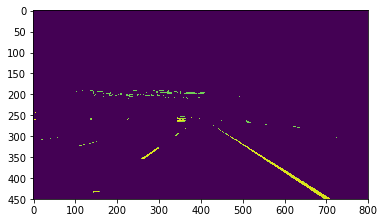

In [25]:
image = cv2.imread('new/10.jpeg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
lower_yellow = np.array([20, 100, 100], dtype = "uint8")
upper_yellow = np.array([30, 255, 255], dtype="uint8")
mask_yellow = cv2.inRange(image, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_image, 200, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
plt.imshow(mask_yw_image)
plt.show()

In [19]:
def Convolution2D(img,filter2D):
    dst = cv2.filter2D(img,-1,filter2D)
    return dst

In [22]:
def HiPassFileter(img):
    mean_filter = np.ones((3,3))
    x = cv2.getGaussianKernel(5,10)
    gaussian = x*x.T
    filters = [gaussian]
    filter_name = ['gaussian']
    fft_filters = [np.fft.fft2(x) for x in filters]
    fft_shift = [np.fft.fftshift(y) for y in fft_filters]
    mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]
    dst = Convolution2D(img,filters[0])
    plt.imshow(dst)
    plt.show()
    return dst

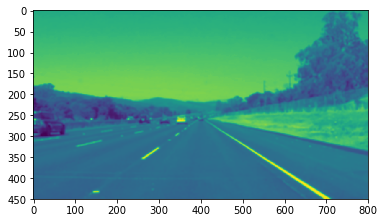

In [28]:
kernel_size = 5
gauss_gray = HiPassFileter(gray_image)

In [29]:
low_threshold = 50
high_threshold = 150
canny_edges = cv2.canny(gauss_gray,low_threshold,high_threshold)

AttributeError: 'module' object has no attribute 'canny'

In [30]:
roi_image = cv2.region_of_interest(canny_edges, vertices)

AttributeError: 'module' object has no attribute 'region_of_interest'

In [ ]:
complete = cv2.addWeighted(initial_img, alpha, line_image, beta, lambda)